In [1]:
import base64
import json
import os
import requests
import pandas as pd
from prophet import Prophet
from tqdm import tqdm
import matplotlib.pyplot as plt
from dotenv import load_dotenv
from utils import upload
import dropbox
import time
import datetime

load_dotenv()

def upload_to_dropbox(dbx, fullname, folder, subfolder, name, overwrite=False):
    """Upload a file.
    Return the request response, or None in case of error.
    """
    path = '/%s/%s/%s' % (folder, subfolder.replace(os.path.sep, '/'), name)
    while '//' in path:
        path = path.replace('//', '/')
    mode = (dropbox.files.WriteMode.overwrite
            if overwrite
            else dropbox.files.WriteMode.add)
    mtime = os.path.getmtime(fullname)
    with open(fullname, 'rb') as f:
        data = f.read()
    try:
        res = dbx.files_upload(
            data, path, mode,
            client_modified=datetime.datetime(*time.gmtime(mtime)[:6]),
            mute=True)
        check_for_links = dbx.sharing_list_shared_links(path)
        if check_for_links.links:
            link_to_file = check_for_links.links[0].url
        else:
            shared_link_metadata = dbx.sharing_create_shared_link_with_settings(path)
            link_to_file = shared_link_metadata.url

    except dropbox.exceptions.ApiError as err:
        print('*** API error', err)
        return None
    print('uploaded as', res.name.encode('utf8'))
    return link_to_file

allData = pd.read_csv(
    'https://www.dropbox.com/scl/fi/ksf0nbmmiort5khbrgr61/allData.csv?rlkey=75e735fjk4ifttjt553ukxt3k&dl=1')
allData.ds = pd.to_datetime(allData.ds)

df = allData.copy()
df.ds = pd.to_datetime(df.ds)

df['total_tbs'] = df[['TRG_HALLWAY_TBS',
                      'POD_GREEN_TBS',
                      'POD_YELLOW_TBS',
                      'POD_ORANGE_TBS',
                      'RAZ_TBS',
                      'AMBVERTTBS',
                      'QTrack_TBS',
                      'Garage_TBS']].sum(axis=1)
df['vert_tbs'] = df[[
    'RAZ_TBS',
    'AMBVERTTBS',
    'QTrack_TBS',
    'Garage_TBS']].sum(axis=1)
df['pod_tbs'] = df[['TRG_HALLWAY_TBS',
                    'POD_GREEN_TBS',
                    'POD_YELLOW_TBS',
                    'POD_ORANGE_TBS',
                    ]].sum(axis=1)
df.tail()

tbs_columns = ['total_tbs', 'vert_tbs', 'pod_tbs']

output = pd.DataFrame()
FIRST_RUN = True

for column in tqdm(tbs_columns):
    if column in ['ds']:
        continue
    try:
        print('working on '+column)

        m = Prophet(interval_width=0.95)
        m.fit(df[['ds', column]].rename(columns={column: 'y'}))
        future = m.make_future_dataframe(periods=24*1, freq='h')
        # forecast = m.predict(future.tail(24*14))
        forecast = m.predict(future)
        if FIRST_RUN:
            output['ds'] = forecast['ds']

        for forecast_column in ['yhat', 'yhat_lower', 'yhat_upper']:
            kwargs = {column+'_'+forecast_column: forecast[forecast_column]}
            output = output.assign(**kwargs)
        FIRST_RUN = False
    except:
        print(column + ' failed')

data = df.copy()
alerts = []
critical_alerts = []




  0%|          | 0/3 [00:00<?, ?it/s]

working on total_tbs


23:31:12 - cmdstanpy - INFO - Chain [1] start processing
23:31:28 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:24<00:48, 24.47s/it]

working on vert_tbs


23:31:36 - cmdstanpy - INFO - Chain [1] start processing
23:31:52 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:48<00:24, 24.44s/it]

working on pod_tbs


23:32:00 - cmdstanpy - INFO - Chain [1] start processing
23:32:09 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [01:05<00:00, 21.73s/it]


In [ ]:
total_tbs_np = pd.read_csv('https://www.dropbox.com/scl/fi/w82obtpfnxdtdaq5zoran/total_tbs_np.csv?rlkey=bndevo6c0qi0bdi5ponko99ej&st=34o472dp&dl=1')
total_tbs_np.ds = pd.to_datetime(total_tbs_np.ds)
total_tbs_np = total_tbs_np.set_index(pd.to_datetime(total_tbs_np['ds']).dt.hour)
most_recent_timestamp = pd.to_datetime(data['ds']).iloc[-1]
total_tbs_np = total_tbs_np[total_tbs_np['ds'].dt.date == most_recent_timestamp.date()]
total_tbs_np

,ds,yhat,yhat_lower,yhat_upper
ds,,,,
0,2025-02-19 00:00:00,16.538969,13.610582,20.488405
1,2025-02-19 01:00:00,15.210392,12.579140,18.337399
2,2025-02-19 02:00:00,14.798574,12.164926,17.934587
3,2025-02-19 03:00:00,11.027762,8.597665,13.628913
4,2025-02-19 04:00:00,8.709942,6.534885,11.161106
5,2025-02-19 05:00:00,5.636923,3.735118,7.589581
6,2025-02-19 06:00:00,4.275831,2.634586,6.073664
7,2025-02-19 07:00:00,5.556340,4.000165,7.176097


In [10]:
most_recent_timestamp = pd.to_datetime(data['ds']).iloc[-1]
most_recent_hour = most_recent_timestamp.hour
most_recent_timestamp.date()

datetime.date(2025, 2, 13)

In [12]:
total_tbs_np = total_tbs_np[total_tbs_np['ds'].dt.date == most_recent_timestamp.date()]
total_tbs_np

,ds,yhat,yhat_lower,yhat_upper
ds,,,,
21,2025-02-13 21:00:00,10.405288,9.079833,17.700245
22,2025-02-13 22:00:00,9.400983,6.659648,13.468894
23,2025-02-13 23:00:00,10.269199,6.971816,12.485955


In [3]:
total_tbs_np['Hour'] = pd.to_datetime(total_tbs_np['ds']).dt.hour
total_tbs_np = total_tbs_np.set_index(total_tbs_np['Hour'])
total_tbs_np.drop('Hour', axis=1, inplace=True)
total_tbs_np

,ds,yhat,yhat_lower,yhat_upper
Hour,,,,
21,2025-02-13 21:00:00,10.405288,9.079833,17.700245
22,2025-02-13 22:00:00,9.400983,6.659648,13.468894
23,2025-02-13 23:00:00,10.269199,6.971816,12.485955
0,2025-02-14 00:00:00,12.833035,9.208324,15.127697
1,2025-02-14 01:00:00,13.221777,9.530045,13.221777
2,2025-02-14 02:00:00,12.202641,9.628290,15.267538
3,2025-02-14 03:00:00,9.451268,7.090091,11.405682
4,2025-02-14 04:00:00,9.457160,4.249186,12.052245


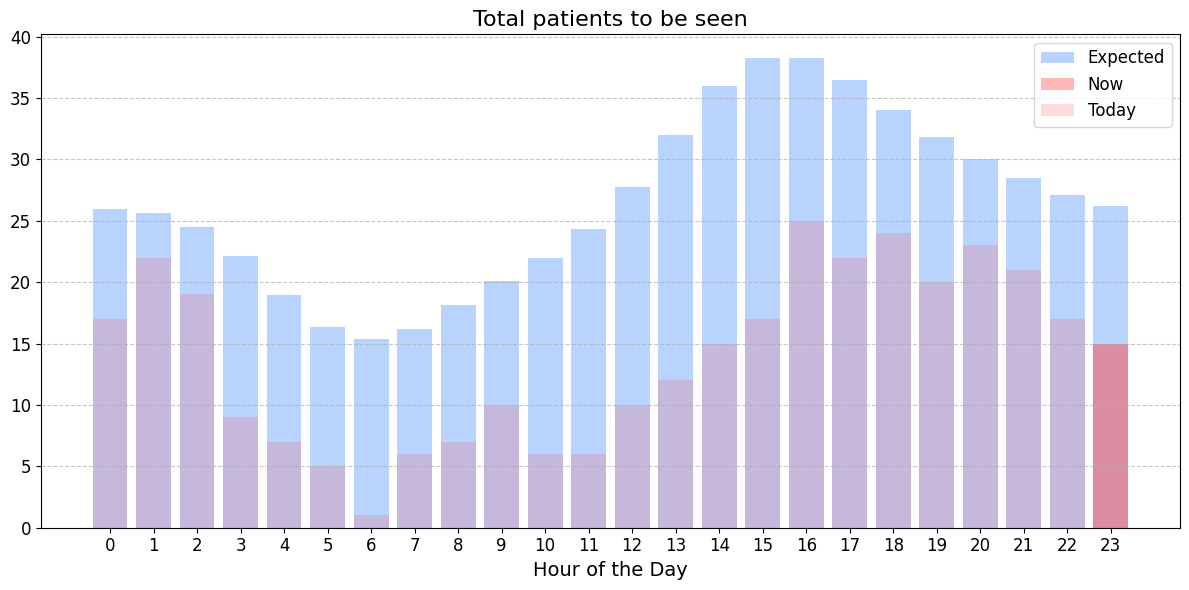

In [4]:

metric = 'total_tbs'

# Calculate total patients to be seen as the sum of specified columns

# Extract hour from the timestamp for grouping
data['Hour'] = pd.to_datetime(data['ds']).dt.hour

# Group by hour and calculate the average number of patients for each hour
hourly_data = data.groupby('Hour')[metric].mean()

# Identify the most recent timestamp's hour and its corresponding value
most_recent_timestamp = pd.to_datetime(data['ds']).iloc[-1]
most_recent_hour = most_recent_timestamp.hour
most_recent_value = data.loc[pd.to_datetime(
    data['ds']) == most_recent_timestamp, metric].iloc[0]
recent_data = data.loc[pd.to_datetime(data['ds']) >= pd.to_datetime(
    most_recent_timestamp.date()), metric]
recent_data = recent_data.reset_index(drop=True)

# Extract the day of the week for the most recent timestamp
most_recent_day_of_week = most_recent_timestamp.dayofweek

# Filter the data to include only rows matching the same day of the week
same_day_data = data[pd.to_datetime(
    data['ds']).dt.dayofweek == most_recent_day_of_week]

# Group by hour and calculate the average number of patients for this specific day of the week
hourly_data_same_day = same_day_data.groupby('Hour')[metric].mean()

prophet_data = output[['ds', metric+'_yhat',
                        metric+'_yhat_lower', metric+'_yhat_upper']].copy()
prophet_data['Hour'] = pd.to_datetime(prophet_data['ds']).dt.hour
prophet_data_today = prophet_data[prophet_data.ds.dt.date ==
                                    most_recent_timestamp.date()]
prophet_data_today = prophet_data_today.reset_index(drop=True)

prophet_data_today.tail()
# Plot the updated graph with colors matching the example and no vertical grid lines
plt.figure(figsize=(12, 6))
# plt.bar(hourly_data_same_day.index, hourly_data_same_day, color='#5293ff', alpha=0.4, label='Expected')
plt.bar(prophet_data_today.index,
        prophet_data_today[metric+'_yhat'], color='#5293ff', alpha=0.4, label='Expected')

plt.bar(
    most_recent_hour, most_recent_value, color='#ff4d4d', alpha=0.4, label='Now'
)
plt.bar(
    recent_data.index, recent_data, color='#ff4d4d', alpha=0.2, label='Today'
)
plt.xlabel('Hour of the Day', fontsize=14)
# plt.ylabel(metric, fontsize=14)
if metric == 'total_tbs':
    plt.title('Total patients to be seen', fontsize=16)
elif metric == 'vert_tbs':
    plt.title('Vertical patients to be seen', fontsize=16)
elif metric == 'pod_tbs':
    plt.title('Pod patients to be seen', fontsize=16)
else:
    plt.title(metric, fontsize=16)
plt.xticks(range(0, 24), fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.grid(False, axis='x')  # Remove vertical grid lines
plt.tight_layout()
# plt.show()
# plt.savefig(metric+'.png')


In [11]:
prophet_data_today

,ds,total_tbs_yhat,total_tbs_yhat_lower,total_tbs_yhat_upper,Hour
0,2025-02-12 00:00:00,26.443059,10.191799,43.171768,0
1,2025-02-12 01:00:00,26.071045,9.069394,41.325241,1
2,2025-02-12 02:00:00,24.921163,9.269084,41.535380,2
3,2025-02-12 03:00:00,22.525696,6.507527,39.752202,3
4,2025-02-12 04:00:00,19.369766,3.196522,35.174351,4
5,2025-02-12 05:00:00,16.720133,0.907708,32.539076,5
6,2025-02-12 06:00:00,15.732915,-0.192498,31.734299,6
7,2025-02-12 07:00:00,16.606335,0.028636,33.181017,7
8,2025-02-12 08:00:00,18.551536,2.440794,35.169891,8
9,2025-02-12 09:00:00,20.606357,3.990339,37.000409,9


In [15]:
total_tbs_np.index

Index([0, 1, 2, 3, 4, 5, 6, 7], dtype='int32', name='ds')

In [13]:
for i,item in total_tbs_np.iterrows():
    print(item.index)

Index(['ds', 'yhat', 'yhat_lower', 'yhat_upper'], dtype='object')
Index(['ds', 'yhat', 'yhat_lower', 'yhat_upper'], dtype='object')
Index(['ds', 'yhat', 'yhat_lower', 'yhat_upper'], dtype='object')
Index(['ds', 'yhat', 'yhat_lower', 'yhat_upper'], dtype='object')
Index(['ds', 'yhat', 'yhat_lower', 'yhat_upper'], dtype='object')
Index(['ds', 'yhat', 'yhat_lower', 'yhat_upper'], dtype='object')
Index(['ds', 'yhat', 'yhat_lower', 'yhat_upper'], dtype='object')
Index(['ds', 'yhat', 'yhat_lower', 'yhat_upper'], dtype='object')


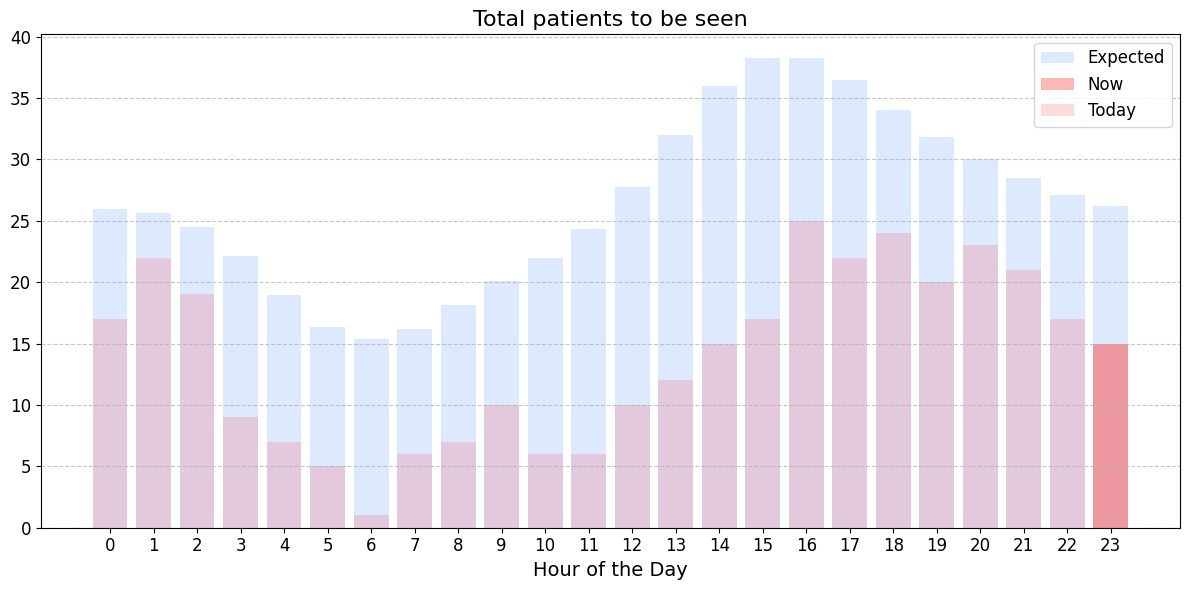

In [32]:
import math

total_tbs_np = pd.read_csv('https://www.dropbox.com/scl/fi/w82obtpfnxdtdaq5zoran/total_tbs_np.csv?rlkey=bndevo6c0qi0bdi5ponko99ej&st=34o472dp&dl=1')
total_tbs_np.ds = pd.to_datetime(total_tbs_np.ds)
total_tbs_np = total_tbs_np.set_index(pd.to_datetime(total_tbs_np['ds']).dt.hour)
most_recent_timestamp = pd.to_datetime(data['ds']).iloc[-1]
total_tbs_np = total_tbs_np[total_tbs_np['ds'].dt.date == most_recent_timestamp.date()]

# Plot the updated graph with colors matching the example and no vertical grid lines
plt.figure(figsize=(12, 6))
# plt.bar(total_tbs_np.index, total_tbs_np.yhat, color='green', alpha=0.1, label='Forecasted')
my_index=0
for index,row in total_tbs_np.iterrows():
    my_index = my_index+1
    if my_index == 1:
        plt.bar(index, row.yhat, color='green', alpha=0.4*(math.pow(0.8,my_index)), label='Forecasted')
    else:
        plt.bar(index, row.yhat, color='green', alpha=0.4*(math.pow(0.8,my_index)))
plt.bar(prophet_data_today.index,
        prophet_data_today[metric+'_yhat'], color='#5293ff', alpha=0.2, label='Expected')

plt.bar(
    most_recent_hour, most_recent_value, color='#ff4d4d', alpha=0.4, label='Now'
)
plt.bar(
    recent_data.index, recent_data, color='#ff4d4d', alpha=0.2, label='Today'
)
plt.xlabel('Hour of the Day', fontsize=14)
# plt.ylabel(metric, fontsize=14)
if metric == 'total_tbs':
    plt.title('Total patients to be seen', fontsize=16)
elif metric == 'vert_tbs':
    plt.title('Vertical patients to be seen', fontsize=16)
elif metric == 'pod_tbs':
    plt.title('Pod patients to be seen', fontsize=16)
else:
    plt.title(metric, fontsize=16)
plt.xticks(range(0, 24), fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.grid(False, axis='x')  # Remove vertical grid lines
plt.tight_layout()

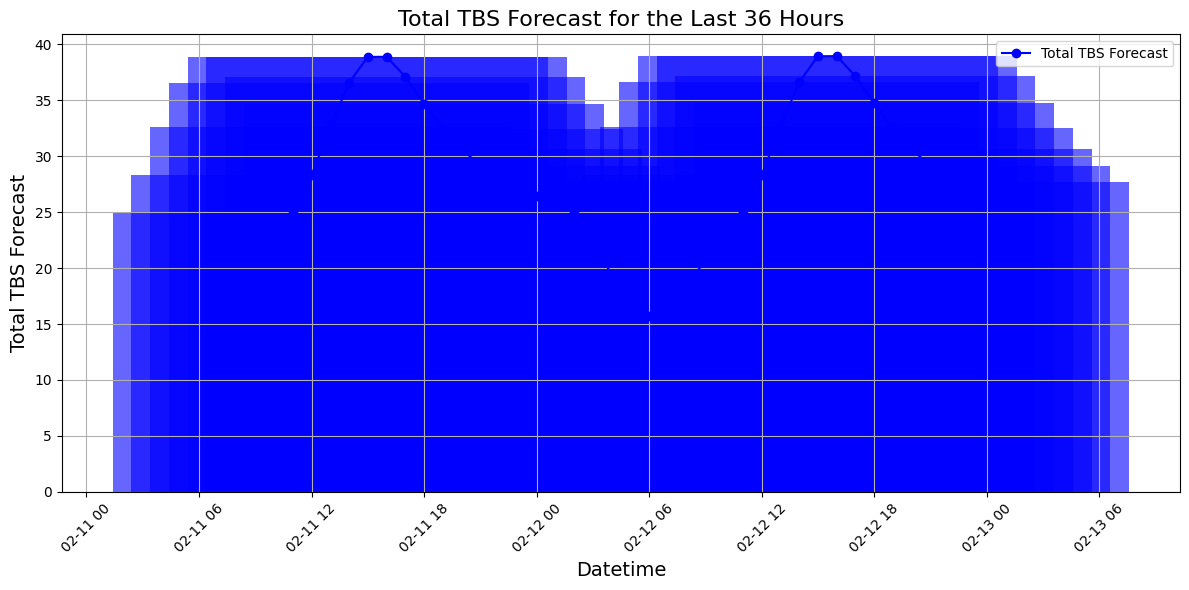

In [14]:
plt.figure(figsize=(12, 6))
plt.plot(prophet_data.tail(36)['ds'], prophet_data.tail(36)['total_tbs_yhat'], marker='o', linestyle='-', color='b', label='Total TBS Forecast')
plt.xlabel('Datetime', fontsize=14)
plt.ylabel('Total TBS Forecast', fontsize=14)
plt.title('Total TBS Forecast for the Last 36 Hours', fontsize=16)
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.bar(prophet_data.tail(36)['ds'], prophet_data.tail(36)['total_tbs_yhat'], color='b', alpha=0.6, label='Total TBS Forecast')
plt.tight_layout()
plt.show()